# Notebook 02 — FFT-Based Carpet Severity Metric (Part 1)

This notebook implements the carpet severity metric required by the challenge.

Challenge-aligned definition:
- Carpet: spectral peaks randomly close to each other (irregular spacing)
- Non-carpet: regularly spaced peaks (harmonic-like spacing)

Why FFT (vs Welch PSD):
Welch PSD is a stable diagnostic representation (Notebook 01), but it can smooth peak microstructure.
Because the challenge requires analysis of peak spacing regularity, we use FFT magnitude to preserve
peak positions and spacing information.

Deliverables from this notebook:
1. Peak extraction in a target frequency band (>= 1000 Hz).
2. Metrics that quantify irregular peak spacing and peak clustering.
3. A carpet severity score per sample.
4. Identification of the sample with the worst carpet symptom.


## 1. Setup and Data Access

This section imports utilities from the repository and defines global parameters used consistently across all samples.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from tractian_cm.io.loaders import load_part1_wave_csv


In [2]:
def fft_magnitude_single_sided(x: np.ndarray, fs: float) -> tuple[np.ndarray, np.ndarray]:
    """
    EN: Compute single-sided FFT magnitude with Hann window to reduce leakage.
    EN: Returns frequency axis (Hz) and magnitude spectrum (linear).
    """
    x = np.asarray(x, dtype=float)
    n = x.size

    # EN: Detrend by removing mean (DC)
    x = x - np.mean(x)

    # EN: Apply Hann window
    w = np.hanning(n)
    xw = x * w

    # EN: rFFT -> single-sided spectrum
    X = np.fft.rfft(xw)
    f = np.fft.rfftfreq(n, d=1.0 / fs)

    # EN: Magnitude normalization (relative comparison; not absolute calibration)
    mag = np.abs(X) / (np.sum(w) / 2.0)

    return f, mag


## 2. FFT Magnitude Spectrum (Single-Sided)

We compute the single-sided FFT magnitude spectrum to preserve peak microstructure.

Key choices:
- Use a window (Hann) to reduce leakage.
- Use amplitude normalization only for comparability (absolute scale is not required).
- Focus on frequencies >= 1000 Hz as specified by the challenge.


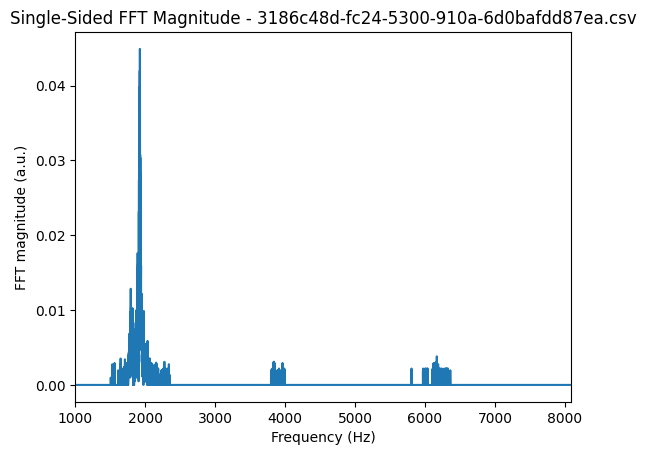

In [4]:
p = Path("../data/part_1/3186c48d-fc24-5300-910a-6d0bafdd87ea.csv")

wave, fs = load_part1_wave_csv(p)
x = np.asarray(wave.signal, dtype=float)

f, mag = fft_magnitude_single_sided(x, fs)

band = f >= 1000.0
plt.figure()
plt.plot(f[band], mag[band])
plt.xlim(1000, f.max())
plt.xlabel("Frequency (Hz)")
plt.ylabel("FFT magnitude (a.u.)")
plt.title(f"Single-Sided FFT Magnitude - {p.name}")
plt.show()


## 3. Peak Extraction

We extract peaks from the FFT magnitude spectrum within the analysis band.

Peak detection must be robust to different global amplitudes across samples, so thresholds are defined relative to a local / global baseline (e.g., median + k * MAD).


## 4. Metrics for Carpet vs Non-Carpet

We propose and compare metrics designed to differentiate:
- Regularly spaced peaks (harmonic-like): low variability in peak-to-peak spacing
- Irregularly clustered peaks (carpet-like): high variability + high local density

Candidate metrics:
1) Spacing variability: CV of Δf between consecutive peak frequencies
2) Local peak density: peaks per kHz (or peaks per window)
3) Periodicity penalty: strength of periodic spacing (optional, via autocorrelation of peak indicator sequence)


## 5. Carpet Severity Score

We define a severity score that increases with:
- Peak density (more peaks per band)
- Spacing irregularity (higher CV of Δf)
and is reduced when the spectrum is dominated by one or a few peaks (peak dominance filter).

We then compute the score per sample and rank samples to identify the worst carpet symptom.


## 6. Ranking and Diagnostics

We generate:
- A ranking table (sample, fs, RMS, score, number of peaks, spacing metrics)
- Diagnostic plots for top-ranked samples:
  - FFT magnitude with detected peaks annotated
  - Peak spacing histogram (or Δf sequence)
